# Example use case: Common-envelope evolution

In this notebook we look at how common-envelope evolution (CEE) alters binary-star orbits. We construct a population of low- and intermediate-mass binaries and compare their orbital periods before and after CEE. Not all stars evolve into this phase, so we have to run a whole population to find those that do. We then have to construct the pre- and post-CEE distributions and plot them.

First, we import a few required Python modules. 

In [1]:
import os
import math
import matplotlib.pyplot as plt
from binarycpython.utils.functions import temp_dir
from binarycpython.utils.grid import Population

TMP_DIR = temp_dir("notebooks", "notebook_comenv")
VERBOSITY = 0

## Setting up the Population object
We set up a new population object. Our stars evolve to $13.7\text{ }\mathrm{Gyr}$, the age of the Universe, and we assume the metallicity $Z=0.02$. We also set the common-envelope ejection efficiency $\alpha_\mathrm{CE}=1$ and the envelope structure parameter $\lambda=0.5$. More complex options are available in *binary_c*, such as $\lambda$ based on stellar mass, but this is just a demonstration example so let's keep things simple.

In [2]:
# Create population object
population = Population()
population.set(
    # grid options
    tmp_dir = TMP_DIR,
    verbosity = VERBOSITY,
    log_dt = 10, # log progress every 10 seconds

    # binary-star evolution options
    max_evolution_time=13700,  # maximum stellar evolution time in Myr (13700 Myr == 13.7 Gyr)
    metallicity=0.02, # 0.02 is approximately Solar metallicity 
    alpha_ce = 1.0,
    lambda_ce = 0.5,
)

## Stellar Grid
We now construct a grid of stars, varying the mass from $1$ to $6\text{ }\mathrm{M}_\odot$. We avoid massive stars for now, and focus on the (more common) low- and intermediate-mass stars. We also limit the period range to $10^4\text{ }\mathrm{d}$ because systems with longer orbital periods will probably not undergo Roche-lobe overflow and hence common-envelope evolution is impossible.

In [3]:
# Set resolution and mass range that we simulate
resolution = {"M_1": 10, "q" : 10, "per": 10} 
massrange = [1, 6] 
logperrange = [0.15, 4]

population.add_grid_variable(
    name="lnm1",
    longname="Primary mass",
    valuerange=massrange,
    samplerfunc="self.const_linear(math.log({min}), math.log({max}), {res})".format(min=massrange[0],max=massrange[1],res=resolution["M_1"]),
    precode="M_1=math.exp(lnm1)",
    probdist="self.three_part_powerlaw(M_1, 0.1, 0.5, 1.0, 150, -1.3, -2.3, -2.3)*M_1",
    dphasevol="dlnm1",
    parameter_name="M_1",
    condition="",  # Impose a condition on this grid variable. Mostly for a check for yourself
)

# Mass ratio
population.add_grid_variable(
     name="q",
     longname="Mass ratio",
     valuerange=["0.1/M_1", 1],
     samplerfunc="self.const_linear({}/M_1, 1, {})".format(massrange[0],resolution['q']),
     probdist="self.flatsections(q, [{{'min': {}/M_1, 'max': 1.0, 'height': 1}}])".format(massrange[0]),
     dphasevol="dq",
     precode="M_2 = q * M_1",
     parameter_name="M_2",
     condition="",  # Impose a condition on this grid variable. Mostly for a check for yourself
)

# Orbital period
population.add_grid_variable(
    name="log10per", # in days
    longname="log10(Orbital_Period)",
    valuerange=[0.15, 5.5],
    samplerfunc="self.const_linear({}, {}, {})".format(logperrange[0],logperrange[1],resolution["per"]),
    precode="""orbital_period = 10.0 ** log10per
sep = calc_sep_from_period(M_1, M_2, orbital_period)
sep_min = calc_sep_from_period(M_1, M_2, 10**{})
sep_max = calc_sep_from_period(M_1, M_2, 10**{})""".format(logperrange[0],logperrange[1]),
    probdist="self.sana12(M_1, M_2, sep, orbital_period, sep_min, sep_max, math.log10(10**{}), math.log10(10**{}), {})".format(logperrange[0],logperrange[1],-0.55),
    parameter_name="orbital_period",
    dphasevol="dlog10per",
)

## Logging and handling the output

We now construct the pre- and post-common envelope evolution data for the first common envelope that forms in each binary. We look at the comenv_count variable, we can see that when it increases from 0 to 1 we have found our object. If this happens, we stop evolution of the system to save CPU time.

In [4]:
custom_logging_statement = """

/*
 * Detect when the comenv_count increased 
 */
if(stardata->model.comenv_count == 1 && 
   stardata->previous_stardata->model.comenv_count == 0)
{
   /*
    * We just had this system's first common envelope:
    * output the time at which this happens, 
    * the system's probability (proportional to the number of stars),
    * the previous timestep's (pre-comenv) orbital period (days) and
    * the current timestep (post-comenv) orbital period (days)
    */
    Printf("COMENV %g %g %g %g\\n",
           stardata->model.time,
           stardata->model.probability,
           stardata->previous_stardata->common.orbit.period * YEAR_LENGTH_IN_DAYS,
           stardata->common.orbit.period * YEAR_LENGTH_IN_DAYS);
           
    /*
     * We should waste no more CPU time on this system now we have the
     * data we want.
     */
    stardata->model.evolution_stop = TRUE;
}
"""

population.set(
    C_logging_code=custom_logging_statement
)


The parse function must now catch lines that start with "COMENV" and process the associated data. We set up the parse_data function to do just this.

In [5]:
from binarycpython.utils.functions import bin_data, datalinedict
import re

# log-period distribution bin width (dex)
binwidth = 0.5 

def parse_function(self, output):
    """
    Parsing function to convert HRD data into something that Python can use
    """
    
    # list of the data items
    parameters = ["header", "time", "probability", "pre_comenv_period", "post_comenv_period"]
    
    # Loop over the output.
    for line in output.splitlines():
        
        # obtain the line of data in dictionary form 
        linedata = datalinedict(line,parameters)

        # choose COMENV lines of output
        if linedata["header"] == "COMENV":
            # bin the pre- and post-comenv log10-orbital-periods to nearest 0.5dex
            binned_pre_period = bin_data(math.log10(linedata["pre_comenv_period"]), binwidth)
            
            # but check if the post-comenv period is finite and positive: if 
            # not, the system has merged and we give it an aritifical period
            # of 10^-100 days (which is very much unphysical)
            if linedata["post_comenv_period"] > 0.0:
                binned_post_period = bin_data(math.log10(linedata["post_comenv_period"]), binwidth)
            else:
                binned_post_period = bin_data(-100,binwidth) # merged!
                
            # make the "histograms"
            self.grid_results['pre'][binned_pre_period] += linedata["probability"]
            self.grid_results['post'][binned_post_period] += linedata["probability"]
            
    # verbose reporting
    #print("parse out results_dictionary=",self.grid_results)
    
# Add the parsing function
population.set(
    parse_function=parse_function,
)

## Evolving the grid
Now we actually run the population. This may take a little while. You can set num_cores higher if you have a powerful machine.

In [6]:
# set number of threads
population.set(
    # set number of threads (i.e. number of CPU cores we use)
    num_cores=4,
    verbosity=VERBOSITY
)

# Evolve the population - this is the slow, number-crunching step
analytics = population.evolve()  

# Show the results (debugging)
#print (population.grid_results)

Do dry run? True
Doing dry run to calculate total starcount and probability
Grid has handled 729 stars with a total probability of 0.0645564
**********************************
*             Dry run            *
*     Total starcount is 729     *
* Total probability is 0.0645564 *
**********************************

Do join of subprocesses ...
Joined subprocesses.
************************************************************
*   Population-e7857f8149e949a286f9bfe35157f91f finished!  *
*            The total probability is 0.0645564.           *
*  It took a total of 25.66s to run 729 systems on 4 cores *
*             = 1 minute and 42.63s of CPU time.           *
*               Maximum memory use 668.594 MB              *
************************************************************

No failed systems were found in this run.
Do analytics
Added analytics to metadata


After the run is complete, some technical report on the run is returned. I stored that in `analytics`. As we can see below, this dictionary is like a status report of the evolution. Useful for e.g. debugging. We check this, and then set about making the plot of the orbital period distributions using Seaborn.

In [7]:
print(analytics)

{'population_id': 'e7857f8149e949a286f9bfe35157f91f', 'evolution_type': 'grid', 'failed_count': 0, 'failed_prob': 0, 'failed_systems_error_codes': [], 'errors_exceeded': False, 'errors_found': False, 'total_probability': 0.06455639233064192, 'total_count': 729, 'start_timestamp': 1655558353.8189669, 'end_timestamp': 1655558379.477376, 'time_elapsed': 25.658409118652344, 'total_mass_run': 3410.9363465845586, 'total_probability_weighted_mass_run': 0.2260906041851175, 'zero_prob_stars_skipped': 0}


Text(0, 0.5, 'Number of stars')

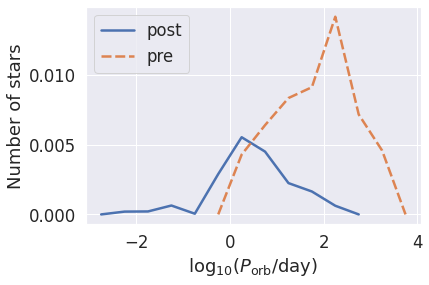

In [8]:
# make a plot of the distributions
import seaborn as sns
import pandas as pd
import copy

from binarycpython.utils.functions import pad_output_distribution

pd.set_option("display.max_rows", None, "display.max_columns", None)


# set up seaborn for use in the notebook
sns.set(rc={'figure.figsize':(20,10)})
sns.set_context("notebook",
                font_scale=1.5,
                rc={"lines.linewidth":2.5})

# remove the merged objects
probability = { "merged" : 0.0, "unmerged" : 0.0}

# copy the results so we can change the copy
results = copy.deepcopy(population.grid_results)

for distribution in ['post']:    
    for logper in population.grid_results[distribution]:
        dprob = results[distribution][logper]
        if logper < -90:
            # merged system
            probability["merged"] += dprob
            del results[distribution][logper]
        else:
            # unmerged system
            probability["unmerged"] += dprob
    
# pad the final distribution with zero
for distribution in population.grid_results:    
    pad_output_distribution(results[distribution],
                            binwidth)
    
# make pandas dataframe 
plot_data = pd.DataFrame.from_dict(results, orient='columns')

# make the plot
p = sns.lineplot(data=plot_data)
p.set_xlabel("$\log_{10} (P_\mathrm{orb} / \mathrm{day})$")
p.set_ylabel("Number of stars")

You can see that common-envelope evolution shrinks stellar orbits, just as we expect. Pre-CEE, most orbits are in the range $10$ to $1000\text{ }\mathrm{d}$, while after CEE the distribution peaks at about $1\text{ }\mathrm{d}$. Some of these orbits are very short: $\log_{10}(-2) = 0.01\text{ }\mathrm{d}\sim10\text{ }\mathrm{minutes}$. Such systems are prime candidates for exciting astrophysics: novae, type Ia supernovae and gravitational wave sources.

Things to try:

 * Extend the logging to output more data than just the orbital period.
 * What are the stellar types of the post-common envelope systems? Are they likely to undergo novae or a type-Ia supernova?
 * What are the lifetimes of the systems in close ($<1\text{ }\mathrm{d}$) binaries? Are they likely to merge in the life of the Universe?
 * How much mass is lost in common-envelope interactions?
 * Extend the grid to massive stars. Do you see many NS and BH compact binaries?
 * Try different $\alpha_\mathrm{CE}$ and $\lambda_\mathrm{CE}$ options...
 * ... and perhaps increased resolution to obtain smoother curves.
 * Why do long-period systems not reach common envelope evolution?